In [1]:
!pip install tensorflow-io

In [3]:
from os import listdir
from pickle import dump
from pickle import load
from keras.applications.resnet import ResNet50
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from keras.applications.resnet import preprocess_input
from keras.models import Model
import numpy as np
from keras.preprocessing.text import Tokenizer
from collections import Counter
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.utils import plot_model
from keras.utils import pad_sequences
from keras.models import load_model

In [4]:
base_model = ResNet50(weights='imagenet')
base_model.summary()

102967424/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                        

In [6]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

In [7]:
img_features = dict()
for file in listdir('/kaggle/input/vr-2dataset/Flicker8k_Images-20230514T050950Z-001/Flicker8k_Images'):
    img_path = '/kaggle/input/vr-2dataset/Flicker8k_Images-20230514T050950Z-001/Flicker8k_Images/' + file
    img = load_img(img_path, target_size=(224, 224)) #size is 224,224 by default
    x = img_to_array(img) #change to numpy array
    x = np.expand_dims(x, axis=0) #include batch dim at the beginning
    x = preprocess_input(x) #make input confirm to resnet50 input format
    avg_features = model.predict(x) #feature extraction
    
    name_id = file.split('.')[0] #take the file name and use as id in dict
    img_features[name_id] = avg_features


1/1 [==============================] - 0s 23ms/step


In [8]:
dump(img_features, open('img_features.pkl', 'wb')) 

In [9]:
def load_data(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    
    dataset = list()
    for image_id in text.split('\n'):
        if len(image_id) < 1:
            continue
            
        dataset.append(image_id)
    
    return set(dataset)

In [10]:
training_set = load_data('/kaggle/input/vr-2dataset/Flickr8k_text-20230514T050950Z-001/Flickr8k_text/Flickr_8k.trainImages.txt')
val_set = load_data('/kaggle/input/vr-2dataset/Flickr8k_text-20230514T050950Z-001/Flickr8k_text/Flickr_8k.valImages.txt')
test_set = load_data('/kaggle/input/vr-2dataset/Flickr8k_text-20230514T050950Z-001/Flickr8k_text/Flickr_8k.testImages.txt')

In [11]:
import string
filename = '/kaggle/input/vr-2dataset/Flickr8k_text-20230514T050950Z-001/Flickr8k_text/Flickr8k.token.txt'
file = open(filename, 'r')
token_text = file.read()
file.close()

translator = str.maketrans("","", string.punctuation) #translation table that maps all punctuation to None
image_captions = dict()
image_captions_train = dict()
image_captions_val = dict()
image_captions_test = dict()
image_captions_other = dict()
corpus = list() #corpus used to train tokenizer
corpus.extend(['<START>', '<END>', '<UNK>']) #add SOS and EOS to list first

max_imageCap_len = 0

for line in token_text.split('\n'): # first split on new line
    tokens = line.split(maxsplit=1) #split on white space, the first segment is 1000268201_693b08cb0e.jpg#0, the following segements are caption texts
    if len(line) < 2:
        continue
    image_id, image_cap = tokens[0], tokens[1:] #use the first segment as image id, the rest as caption
    image_id = image_id.split('#')[0] #strip out #0 from filename
    image_cap = ' '.join(image_cap) #join image caption together again

    image_cap = image_cap.lower() #change to lower case
    image_cap = image_cap.translate(translator) #take out punctuation using a translation table
    
    image_cap = image_cap.split(' ') #split string here because following two methods works on word-level best
    image_cap = [w for w in image_cap if w.isalpha()] #keep only words that are all letters
    image_cap = [w for w in image_cap if len(w)>1]
    image_cap = '<START> ' + ' '.join(image_cap) + ' <END>' #add sentence start/end; note syntax: separator.join()
    
    #update maximum caption length
    if len(image_cap.split()) > max_imageCap_len:
        max_imageCap_len = len(image_cap.split())
    
    #add to dictionary
    if image_id not in image_captions:
        image_captions[image_id] = list() #creat a new list if it does not yet exist
    image_captions[image_id].append(image_cap)
    
    #add to train/dev/test dictionaries
    if image_id in training_set:
        if image_id not in image_captions_train:
            image_captions_train[image_id] = list() #creat a new list if it does not yet exist
        image_captions_train[image_id].append(image_cap)
        corpus.extend(image_cap.split()) #add only training words to corpus to train tokenlizer
        
    elif image_id in val_set:
        if image_id not in image_captions_val:
            image_captions_val[image_id] = list() #creat a new list if it does not yet exist
        image_captions_val[image_id].append(image_cap)
        
    elif image_id in test_set:
        if image_id not in image_captions_test:
            image_captions_test[image_id] = list() #creat a new list if it does not yet exist
        image_captions_test[image_id].append(image_cap)
    else:
        if image_id not in image_captions_other:
            image_captions_other[image_id] = list() #creat a new list if it does not yet exist
        image_captions_other[image_id].append(image_cap)

caption_train_tokenizer = Tokenizer() #initialize tokenizer
caption_train_tokenizer.fit_on_texts(corpus) #fit tokenizer on training data
    
info = open("image_captions.pkl","wb")
dump(image_captions, info)
info.close()

info = open("image_captions_train.pkl","wb")
dump(image_captions_train, info)
info.close()

info = open("image_captions_val.pkl","wb")
dump(image_captions_val, info)
info.close()

info = open("image_captions_test.pkl","wb")
dump(image_captions_test, info)
info.close()

info = open("image_captions_other.pkl","wb")
dump(image_captions_other, info)
info.close()

info = open("caption_train_tokenizer.pkl","wb")
dump(caption_train_tokenizer, info)
info.close()

info = open("corpus.pkl","wb")
dump(corpus, info)
info.close()

corpus_count=Counter(corpus)
info = open("corpus_count.pkl","wb")
dump(corpus_count, info)
info.close()

print("size of data =", len(image_captions), "size of training data =", len(image_captions_train), "size of val data =", len(image_captions_val), "size of test data =", len(image_captions_test), "size of unused data =", len(image_captions_other))
print("maximum image caption length =",max_imageCap_len)

size of data = 8092 size of training data = 6000 size of val data = 1000 size of test data = 1000 size of unused data = 92
maximum image caption length = 34


In [12]:
embeddings_index = dict()
info = open('/kaggle/input/glovedata/glove.6B.200d.txt' ,encoding="utf8")
for line in info:
    word_val = line.split()
    word = word_val[0]
    coefs = np.asarray(word_val[1:], dtype='float32')
    embeddings_index[word] = coefs
info.close()


In [13]:
embed_dim = 200
word_index = caption_train_tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embed_dim))

for word, idx in word_index.items():
    embed_vector = embeddings_index.get(word)
    if embed_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[idx] = embed_vector
        
info = open("embedding_matrix.pkl","wb")
dump(embedding_matrix, info)
info.close()

In [14]:
def create_seq(tokenizer, max_length, desc_list, photo, vocab_size):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0] #[0] is used to take out the extra dim. This changes from text to a number
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            # import pdb; pdb.set_trace()
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(np.squeeze(X1)), np.array(X2), np.array(y)

In [15]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length, batch_size, vocab_size):
    # loop for ever over images
    current_batch_size=0
    while 1:
        for key, desc_list in descriptions.items():
            # retrieve the photo feature
            if current_batch_size == 0:
                X1, X2, Y = list(), list(), list()
            
            imageFeature_id = key.split('.')[0]
            photo = photos[imageFeature_id][0]
            in_img, in_seq, out_word = create_seq(tokenizer, max_length, desc_list, photo, vocab_size)
            #in_img = np.squeeze(in_img)
            X1.extend(in_img)
            X2.extend(in_seq)
            Y.extend(out_word)
            current_batch_size += 1
            if current_batch_size == batch_size:
                current_batch_size = 0
                yield [[np.array(X1), np.array(X2)], np.array(Y)]

In [16]:
from pickle import load
# Open the pickle file in binary read mode
with open('/kaggle/working/img_features.pkl', 'rb') as info:
    # Load the image features from the pickle file
    image_features = load(info)


In [17]:
# test the data generator
caption_max_length = 34
batch_size = 1
vocab_size = 7057
generator = data_generator(image_captions_train, image_features, caption_train_tokenizer, caption_max_length, batch_size, vocab_size)
inputs, outputs = next(generator)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)

(47, 2048)
(47, 34)
(47, 7057)


In [18]:
from keras.layers import concatenate
def define_model(vocab_size, max_length, embedding_matrix):
    # feature extractor model
    inputs1 = Input(shape=(2048,))
    image_feature = Dropout(0.3)(inputs1)
    image_feature = Dense(256, activation='relu')(image_feature)
    
    # sequence model
    inputs2 = Input(shape=(max_length,))
    language_feature = Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=max_length, trainable=False)(inputs2)
    
    
    language_feature = Dropout(0.3)(language_feature)
    language_feature = LSTM(256)(language_feature)
    
    # decoder model
    output = concatenate([image_feature, language_feature])
    output = Dense(256, activation='relu')(output)
    output = Dense(vocab_size, activation='softmax')(output)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['acc'])
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model_concat.png', show_shapes=True)
    return model

info = open("embedding_matrix.pkl","rb")
embedding_matrix = load(info)
info.close()

caption_max_length = 34
vocab_size = 7578
post_rnn_model_concat = define_model(vocab_size, caption_max_length, embedding_matrix)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 200)      1515600     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [19]:
info = open("/kaggle/working/img_features.pkl","rb")
image_features = load(info)
info.close()

info = open("caption_train_tokenizer.pkl","rb")
caption_train_tokenizer = load(info)
info.close()

info = open("image_captions_train.pkl","rb")
image_captions_train = load(info)
info.close()

info = open("image_captions_val.pkl","rb")
image_captions_val = load(info)
info.close()

caption_max_length = 34
batch_size = 100
vocab_size = 7578

In [31]:
batch_size = 6
steps = len(image_captions_train)
steps_per_epoch = np.floor(steps/batch_size)

num_epochs = 25

for i in range(num_epochs):
    # create the data generator
    generator = data_generator(image_captions_train, image_features, caption_train_tokenizer, caption_max_length, batch_size, vocab_size)
    # fit for one epoch
    post_rnn_model_concat_hist=post_rnn_model_concat.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    # save model
    post_rnn_model_concat.save('model_1_' + str(i) + '.h5')

/tmp/ipykernel_28/2414715269.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  post_rnn_model_concat_hist=post_rnn_model_concat.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


6000/6000 [==============================] - 185s 31ms/step - loss: 1.6667 - acc: 0.5322


In [20]:
feature_pred_model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)


In [21]:
def extract_feature(model, file_name):
    img = load_img(file_name, target_size=(224, 224)) #size is 224,224 by default
    x = img_to_array(img) #change to np array
    x = np.expand_dims(x, axis=0) #expand to include batch dim at the beginning
    x = preprocess_input(x) #make input confirm to VGG16 input format
    avg_features = model.predict(x)
    return avg_features

In [32]:
# load the tokenizer
caption_train_tokenizer = load(open('caption_train_tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34
# load the model
#pred_model = load_model('model_3_0.h5')
from keras.models import load_model
pred_model = load_model('model_1_24.h5')

In [33]:
def generate_caption(pred_model, caption_train_tokenizer, photo, max_length):
    in_text = '<START>'
    caption_text = list()
    for i in range(max_length):
            # integer encode input sequence
            sequence = caption_train_tokenizer.texts_to_sequences([in_text])[0]
            # pad input
            sequence = pad_sequences([sequence], maxlen=max_length)
            # predict next word
            model_softMax_output = pred_model.predict([photo,sequence], verbose=0)
            # convert probability to integer
            word_index = argmax(model_softMax_output)
            # map integer to word
            word = caption_train_tokenizer.index_word[word_index]
            #print(word)
            # stop if we cannot map the word
            if word is None:
                break
            # append as input for generating the next word
            in_text += ' ' + word
            # stop if we predict the end of the sequence
            if word != 'end':
                caption_text.append(word)
            if word == 'end':
                break
    return caption_text

In [25]:
from numpy import argmax

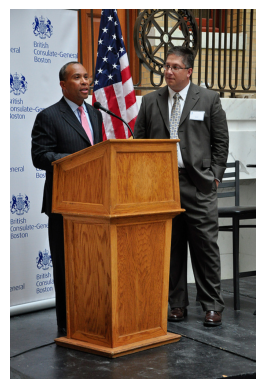

In [41]:
import os
from PIL import Image
import matplotlib.pyplot as plt
image_folder_path = "/kaggle/input/coco-2017-dataset/coco2017/test2017"
image_filename = "000000000202.jpg"
image_path = os.path.join(image_folder_path,image_filename)
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()


In [40]:
caption_image_fileName = '/kaggle/input/coco-2017-dataset/coco2017/test2017/000000000202.jpg'
photo = extract_feature(feature_pred_model, caption_image_fileName)
caption = generate_caption(pred_model, caption_train_tokenizer, photo, max_length)
print(' '.join(caption))


1/1 [==============================] - 0s 22ms/step
man in black hat touches up from another man in black


In [27]:
fid = open("img_features.pkl","rb")
image_features = load(fid)
fid.close()

fid = open("caption_train_tokenizer.pkl","rb")
caption_train_tokenizer = load(fid)
fid.close()

fid = open("image_captions_test.pkl","rb")
image_captions_test = load(fid)
fid.close()

# pre-define the max sequence length (from training)
max_length = 34
# load the model
pred_model = load_model('/kaggle/input/pred-model/model_1_24.h5')
#pred_model = load_model('model_3_0.h5')

In [28]:
image_captions_candidate = dict()
for image_fileName, reference_captions in image_captions_test.items():
    image_fileName_feature = image_fileName.split('.')[0]
           
    photo = img_features[image_fileName_feature]
    image_captions_candidate[image_fileName] = generate_caption(pred_model, caption_train_tokenizer, photo, max_length)
    
fid = open("test_captions_post_concat","wb")
dump(image_captions_candidate, fid)
fid.close()

In [29]:
#greedy bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from pickle import load

fid = open("test_captions_post_concat","rb")
image_captions_candidate = load(fid)
fid.close()


fid = open("image_captions_test.pkl","rb")
image_captions_test = load(fid)
fid.close()

chencherry = SmoothingFunction()

bleu_score = dict()
for image_fileName, reference_captions in image_captions_test.items():
    ref_cap_reformat=list()
    for cap in reference_captions:
        ref_cap_reformat.append(cap.split()[1:-1])
    
    bleu_score[image_fileName] = sentence_bleu(ref_cap_reformat, image_captions_candidate[image_fileName], smoothing_function=chencherry.method1)
    
    
#print(bleu_score)

In [30]:
import numpy as np
bleu_score_array = np.fromiter(bleu_score.values(), dtype=float)
print('mean bleu='+str(np.mean(bleu_score_array)) + '; median bleu='+str(np.median(bleu_score_array))+'; max bleu='+str(np.max(bleu_score_array))+'; min bleu='+str(np.min(bleu_score_array))+'; std bleu='+str(np.std(bleu_score_array)))

mean bleu=0.07846036699346853; median bleu=0.050712153369465586; max bleu=0.6985342056580097; min bleu=0.0; std bleu=0.08546358022843102
